In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from oauth2client.service_account import ServiceAccountCredentials
from datetime import date, datetime, timedelta
import gspread
import json
import re
import pandasql as psql
import sys
import os
from sqlalchemy import create_engine

sys.path.append(r'..\database')
sys.path.append(r'..\services')

import db_connector as connector
import etl_oltp_to_olap as etl
import database.gsheet_connnector as gsheet_conn

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)
warnings.filterwarnings('ignore')
sns.set_style('dark')

2025-10-01 18:36:38.217 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


## **1. Data Collection**

In [2]:
client = gsheet_conn.get_gsheet_credentials()
fitness_personal_key = os.getenv("GOOGLE_SHEET_KEY_FITNESS_PERSONAL")
food_tracking = os.getenv("GOOGLE_SHEET_KEY_FOOD")
spreadsheet_fitness_personal = client.open_by_key(fitness_personal_key)
spreadsheet_food_tracking = client.open_by_key(food_tracking)

In [30]:
# ----- Track Record
sheet = spreadsheet_fitness_personal.worksheet('TrackRecord')
records = sheet.get_all_records()
df = pd.DataFrame.from_records(records)

# ----- Routine Template
templates = spreadsheet_fitness_personal.worksheet('Routines')
templates_data = templates.get_all_records()
df_templates = pd.DataFrame.from_records(templates_data)

# ---- Status
status = spreadsheet_fitness_personal.worksheet('OtherInfoTrackRecord')
data = status.get('A1:E')
header = data[0]
status_records = [dict(zip(header, row)) for row in data[1:]]
df_status = pd.DataFrame.from_records(status_records)

# ---- Target
target = spreadsheet_fitness_personal.worksheet('TargetSets')
target_data = target.get_all_records()
df_target = pd.DataFrame.from_records(target_data)

# ---- Metrics
metrics = spreadsheet_food_tracking.worksheet('Metrics')
metrics_data = metrics.get_all_records()
df_metrics = pd.DataFrame.from_records(metrics_data)

In [ ]:
conn = connector.get_db_connection()
muscle_roles = etl.create_exercise_dimension_table(conn)
workouts = pd.read_sql("SELECT * FROM workouts", con=conn)

🔍 Conexión detectada


In [47]:
def convert_date_columns(df, date_columns: list, multiple_formats=False, desired_format='%Y-%m-%d'):
    """
    Converts specified columns in a DataFrame to datetime format.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        date_columns (list): List of column names to convert to datetime.
        multiple_formats (bool): Indicate if there are multiple columns within the same column.
        desired_format (str): Format used by default.

    Returns:
        pd.DataFrame: DataFrame with converted date columns.
    """
    if multiple_formats == False:
        df[date_columns] = df[date_columns].apply(pd.to_datetime, format=desired_format)
    else:
        for col in date_columns:
            df['fecha_1'] = pd.to_datetime(df[col], format='%Y - %m', errors='coerce')
            df['fecha_2'] = pd.to_datetime(df[col], format='%Y - %m - %d', errors='coerce')
            df['fecha_3'] = pd.to_datetime(df[col], format='%Y-%m-%d', errors='coerce')
            df[col] = df[['fecha_1','fecha_2','fecha_3']].max(1)
            df.drop(['fecha_1', 'fecha_2','fecha_3'], axis=1, inplace=True)

    return df

In [ ]:
# Clean my gsheet
last_set_cleaned = int(workouts.iloc[-1,0])

if any(col in df.columns for col in ['comment', 'workload', 'I/O']):
    df.drop(columns=['comment','workload','I/O'], inplace=True)
df.replace('', np.nan, inplace=True)
df.drop(df[df.notnull().sum(1) == 0].index, inplace=True)

df = df.loc[df.id > last_set_cleaned].copy()

df = convert_date_columns(df, date_columns=['fecha'])

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10913 entries, 0 to 10912
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            10913 non-null  float64
 1   routine_name  10913 non-null  object 
 2   fecha         10913 non-null  object 
 3   exercise      10913 non-null  object 
 4   repmin        10729 non-null  float64
 5   repmax        9143 non-null   float64
 6   repreal       10913 non-null  float64
 7   weight        10913 non-null  float64
 8   rir           10913 non-null  float64
dtypes: float64(6), object(3)
memory usage: 767.4+ KB


In [32]:
df.drop(df[df.notnull().sum(1) == 0].index)

,id,routine_name,fecha,exercise,repmin,repmax,repreal,weight,rir,comment,workload,I/O
0,0,Upper I,2023-01-16,Low cable crossover,6,12,10,10,1,,100,
1,1,Upper I,2023-01-16,Low cable crossover,6,12,10,10,3,,100,
2,2,Upper I,2023-01-16,Low cable crossover,6,12,10,10,4,,100,
3,3,Upper I,2023-01-16,Chin-ups,1,,1,100,1,,100,
4,4,Upper I,2023-01-16,Chin-ups,5,,5,80,5,,400,
...,...,...,...,...,...,...,...,...,...,...,...,...
10909,10909,Upper I,2025-10-01,Hammer curl,,,8,22,3,,176,
10910,10910,Upper I,2025-10-01,Hammer curl,,,8,22,2,,176,
10911,10911,Upper I,2025-10-01,Hammer curl,,,8,22,1,,176,
10912,10912,Upper I,2025-10-01,Hammer curl,,,8,22,1,,176,


In [ ]:
def clean_my_personal_gsheet(df):

,id,routine_name,fecha,exercise,repmin,repmax,repreal,weight,rir,comment,workload,I/O
0,0,Upper I,2023-01-16,Low cable crossover,6,12,10,10,1,,100,
1,1,Upper I,2023-01-16,Low cable crossover,6,12,10,10,3,,100,
2,2,Upper I,2023-01-16,Low cable crossover,6,12,10,10,4,,100,
3,3,Upper I,2023-01-16,Chin-ups,1,,1,100,1,,100,
4,4,Upper I,2023-01-16,Chin-ups,5,,5,80,5,,400,
...,...,...,...,...,...,...,...,...,...,...,...,...
10909,10909,Upper I,2025-10-01,Hammer curl,,,8,22,3,,176,
10910,10910,Upper I,2025-10-01,Hammer curl,,,8,22,2,,176,
10911,10911,Upper I,2025-10-01,Hammer curl,,,8,22,1,,176,
10912,10912,Upper I,2025-10-01,Hammer curl,,,8,22,1,,176,


## **2. Data Cleaning**

In [83]:
def snake_case(df):
    df.columns = df.columns.str.lower().str.replace(' ','_')

def drop_empty_rows(df, fecha_col: str = 'fecha'):
    df.dropna(axis=0, how='all') # Elinimaos filas donde todos los valores son nulos
    df.drop(df[df[fecha_col].isnull()].index, inplace=True) # Eliminamos filas donde la fecha es nula (just in case)
    return df

def convert_date_columns(df, date_columns: list, multiple_formats=False, desired_format='%Y-%m-%d'):
    """
    Converts specified columns in a DataFrame to datetime format.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        date_columns (list): List of column names to convert to datetime.
        multiple_formats (bool): Indicate if there are multiple columns within the same column.
        desired_format (str): Format used by default.

    Returns:
        pd.DataFrame: DataFrame with converted date columns.
    """
    if multiple_formats == False:
        df[date_columns] = df[date_columns].apply(pd.to_datetime, format=desired_format)
    else:
        for col in date_columns:
            df['fecha_1'] = pd.to_datetime(df[col], format='%Y - %m', errors='coerce')
            df['fecha_2'] = pd.to_datetime(df[col], format='%Y - %m - %d', errors='coerce')
            df['fecha_3'] = pd.to_datetime(df[col], format='%Y-%m-%d', errors='coerce')
            df[col] = df[['fecha_1','fecha_2','fecha_3']].max(1)
            df.drop(['fecha_1', 'fecha_2','fecha_3'], axis=1, inplace=True)

    return df

def convert_right_formats(df, int_cols: list = ['reps','rir'], float_cols: list = ['peso']):
    # Right formats
    df = df.replace('',np.nan)
    df[float_cols] = df[float_cols].astype(float)
    df[int_cols] = df[int_cols].astype(int)
    return df

def basic_cleanings(df: pd.DataFrame, 
                    date_columns: list = ['fecha'], 
                    int_cols: list = ['reps','rir'], 
                    float_cols: list = ['peso']):
    snake_case(df)
    df = drop_empty_rows(df)
    df = convert_date_columns(df, date_columns=date_columns)
    df = convert_right_formats(df, int_cols=int_cols, float_cols=float_cols)

    if 'id_set' not in df.columns:
        df.reset_index(names='id_set', inplace=True)
        
    return df

def clean_exercise_col(df, exercise_col: str = 'ejercicio'):
    df[exercise_col] = df[exercise_col].str.capitalize()
    df[exercise_col] = df[exercise_col].str.replace(r'\d+', '', regex=True).str.strip()

    exercise_mapping = {
                            'Preacher curl machine':'Scott machine bicep curl',
                            'Bar wrist flexion':'Barbell Wrist Curl',
                            'Prone barbell curl':'Prone barbell bicep curl',
                            'Wide grip seated row':'Wide grip row',
                            'Ez bar bicep curl':'Barbell Bicep Curl',
                            'Overhead extensions':'Overhead cable triceps extension',
                            'High pulley triceps extension':'Unilateral Cable Triceps Extension',
                            'Rope triceps extension':'Unilateral Cable Triceps Extension',
                            'Seated cable rear delt flyes':'Seated rear delt cable flyes',
                            'Leg curl':'Single-leg leg curl',
                            'Calf machine':'Calf raise on machine',
                            'Machine leg curl':'Seated Leg Curl',
                            'Cable bicep curl': 'Low cable biceps curl - Unilateral'
                        }

    df[exercise_col] = df[exercise_col].apply(lambda x: exercise_mapping.get(x, x))
    df[exercise_col] = df[exercise_col].str.capitalize()

    return df

In [84]:
df = basic_cleanings(df)
df = clean_exercise_col(df)

## **3. Feature Engineering**

**Create table for muscle implied for each set**

In [60]:
def clean_my_personal_gsheet(df):
    """
    Cleans SPECIFICALY my personal gsheet where I track my workouts.
    """
    if 'id' in df.columns:
        df.set_index('id', inplace=True)
    if 'i/o' in df.columns:
        df.drop('i/o', axis=1, inplace=True)
    df['pct_strenght'] = df.repmin.apply(lambda x: int(re.search(r'\((\d+)\%\)', str(x)).group(1)) if isinstance(x, str) and '(' in x else np.nan) # Donde especificamos % de fuerza lo separamos en otra columna
    
    # Limpiamos la columna de rep mínima
    df['exercise'] = np.where(df.repmin.str.contains('muscle', case=False, na=False), 'Muscle Up', df.exercise) # Donde dice muscle up lo ponemos en la columna de `exercise`
    df['repmin'] = df.repmin.apply(lambda x: 1 if isinstance(x,str) and 'muscle' in x.lower() else x) # Donde había Muscle up ponemos un 1 de rep mínima
    df['repmin'] = df['repmin'].apply(lambda x: int(re.search(r'^(\d+)', str(x)).group(1)) if isinstance(x, str) and re.search(r'^(\d+)', str(x)) else x)
    df['repmin'] = df.repmin.replace('',np.nan)
    df.loc[df.repmin == 'F (85%)','pct_strenght'] = 85
    df.loc[df.repmin == 'F (85%)','repmin'] = -1
    df.loc[df.repmin == 0,'repmin'] = 1
    df['repmin'] = df.repmin.astype(float)

    # Limpiamos la columna de rutina
    routine_by_date = df.groupby('date')['routine'].value_counts().reset_index()
    routine_by_date['cumcount'] = routine_by_date.groupby(['date']).cumcount() + 1
    map_routine_by_date = routine_by_date.loc[routine_by_date.cumcount == 1,['date','routine']]
    df_merged = df.merge(map_routine_by_date, how='left', on='date', suffixes=('','_new'))
    df_merged['routine'] = np.where(df_merged.routine_new.notnull(), df_merged.routine_new, df_merged.routine)
    df_merged.drop('routine_new', axis=1, inplace=True)

    # Other columns
    df_merged['routine'] = df_merged['routine'].replace('#N/A',np.nan)
    df_merged['comment'] = df_merged['comment'].replace(['#N/A',''],np.nan)
    df_merged['repmax'] = df_merged['repmax'].replace(['#N/A',''],np.nan)

    # Rename
    df_merged.rename(columns={'date':'fecha'}, inplace=True)

    df_merged = clean_exercise_col(df_merged)

    return df_merged

In [ ]:
def is_a_dropset(df, 
                 exercise_col: str = 'ejercicio', 
                 weight_col: str = 'peso', 
                 repmin_col: str = 'repmin'):
    """
    Used to check if a particular set is a dropset and were
    introduced bad by me.
    """
    df[weight_col] = df[weight_col].astype(float)
    df['exercise_shift'] = df[exercise_col].shift(1)
    df['weight_shift'] = df[weight_col].shift(1)

    df['SoS'] = np.where(df[exercise_col] == df['exercise_shift'], 
                            df[weight_col]/df['weight_shift'] - 1, 
                                np.nan)

    if 'technique' not in df.columns:
        df['technique'] = np.nan

    exercises = [
        'Pull-ups',
        'Ring chin-ups',
        'Chin-ups',
        'Parallel bar dips',
        'Conventional deadlift',
        'Barbell squat',
        'Barbell row',
        'Bench press',
        'Hip thrust',
        'Dumbbell row'
    ]
    df.loc[
        (df['SoS'] < 0) & 
        (df.repmin == -1) & 
        (~df[exercise_col].isin(exercises))
        ,'technique'] = 'D'
    df.loc[
        (df['SoS'] <= -0.2) & 
        (df.repmin != -1) & 
        (df[weight_col] > 20) & 
        (~df[exercise_col].isin(exercises))
        , 'technique'] = 'D'

    df.drop(['SoS','exercise_shift','weight_shift'], axis=1, inplace=True)

    return df

def separate_rango_column(df, rango_col: str = 'rango'):
    """
    Separates the 'Rango' column into 'Rango' and 'Técnica'.
    """
    if rango_col not in df.columns:
        raise ValueError(f"Column '{rango_col}' not found in DataFrame.")

    new_cols = ['repmin','repmax']

    rango_df = df[rango_col].str.split(' - ', expand=True)
    rango_df.columns = new_cols
    df = pd.concat([df, rango_df], axis=1)
    df[new_cols] = df[new_cols].astype(float)
    df.drop('rango', axis=1, inplace=True)

    return df

In [ ]:
df = separate_rango_column(df)
df = is_a_dropset(df)

In [71]:
df

,fecha,ejercicio,reps,peso,rir,repmin,repmax,technique
0,2025-09-21,Scott machine bicep curl,2,5.0,1,6.0,8.0,NaN
1,2025-09-21,Scott machine bicep curl,2,5.0,1,6.0,8.0,NaN
2,2025-09-21,Scott machine bicep curl,2,5.0,2,6.0,8.0,NaN
3,2025-09-21,Scott machine bicep curl,2,5.0,2,6.0,8.0,NaN
4,2025-09-21,Incline barbell press,3,76.0,2,71.0,NaN,NaN
5,2025-09-21,Incline barbell press,3,76.0,2,73.5,NaN,NaN
6,2025-09-21,Incline barbell press,3,76.0,2,NaN,NaN,NaN


In [ ]:
weight_body_exercises = [
    'Chin-ups', 
    'Parallel bar dips',
    'Pull-ups',
    'Muscle-ups',
    'Neutral grip pull-ups',
    'Ring chin-ups',
    'Parallel bar dips 210',
    'Barbell squat'
    ]

def add_workload_column(df):
    """
    Create a new column with the workload of each set.
    """
    df['workload'] = df.peso * df.reps
    return df

def add_rol_multiplier(muscle_roles, sql_roles):
    muscle_roles_merged = muscle_roles.merge(sql_roles[['rol','rol_multiplier']], on='rol', how='left')
    return muscle_roles_merged

def merge_muscleroles_and_dwh(df, df_muscleroles):
    df_muscleroles = df_muscleroles.replace('',np.nan)
    df_muscleroles['english_name'] = df_muscleroles.english_name.str.capitalize()
    ss_muscleroles = df_muscleroles[['muscle_name','rol','english_name','rol_multiplier']].copy()

    # Merge
    df_by_muscle = df.merge(ss_muscleroles, 
                            how='left', 
                            left_on='ejercicio', 
                            right_on='exercise_name'
                            ).drop(['exercise_name'], axis=1)
    
    return df_by_muscle

def add_muscle_analytic_cols(df_by_muscle):
    """
    Create columns specific to the muscles granularity for further analysis.
    """
    df_by_muscle['workload_by_muscle'] = df_by_muscle.workload * df_by_muscle.rol_multiplier
    df_by_muscle['sets_by_muscle'] = np.where(df_by_muscle.rol_multiplier == 1, 1,
                                        np.where(df_by_muscle.rol_multiplier ==  0.1, 0,
                                            0.5))
    df_by_muscle['is_set_principal_for_muscle'] = np.where(df_by_muscle.sets_by_muscle == 1,1,0)

    return df_by_muscle

def merge_target_sets_by_user(df, df_target=None):
    """
    Merge the target sets by user with the data warehouse of the respective to user.
    """
    result = df.copy()

    if df_target is not None:
        query = """
        SELECT df.*, target.Series_min, target.Series_max
        FROM df
        LEFT JOIN df_target AS target ON target.Date <= df.fecha AND target.Exercise = df.principalmuscle 
        """

        result = psql.sqldf(query, locals())
        result['fecha'] = pd.to_datetime(result['fecha'], format='mixed').dt.strftime('%Y-%m-%d')
        result.rename(columns={'Series_min':'target_min','Series_max':'target_max'}, inplace=True)
        result.drop(['principalmuscle','secondary_muscle','secondary_muscle_2'], axis=1, inplace=True)

    return result

def add_cols_analytics_metrics(df_metrics=None):
    """
    Add columns in the metrics (body) dataset for further merge with the dwh. 
    """
    if df_metrics is not None:
        ss_metrics = df_metrics[['fecha','peso']].copy()
        ss_metrics['fecha_prev'] = ss_metrics.fecha.shift(1)
        ss_metrics['peso_prev'] = ss_metrics.peso.shift(1)
        ss_metrics = ss_metrics[['fecha_prev','peso_prev','fecha','peso']]

        ss_metrics['delta_peso'] = ss_metrics.peso - ss_metrics.peso_prev
        ss_metrics['delta_fecha'] = np.round((ss_metrics.fecha - ss_metrics.fecha_prev).dt.days,0)

        ss_metrics['delta_daily'] = np.round(ss_metrics.delta_peso/ss_metrics.delta_fecha,3)

        return ss_metrics
    
    return None

def merge_metrics_dwh(dwh, df_metrics=None, weight_body_exercises: list = weight_body_exercises):
    """
    Merge the metrics dataset with the dwh to compute the real bodyweight
    in each training and added to the total weight lifted in those bodyweight exercises.
    """
    dwh_merged = dwh.copy()

    if df_metrics is not None:
        query = """
        SELECT dwh.*, df_metrics.fecha_prev, df_metrics.peso_prev, df_metrics.delta_daily, df_metrics.fecha AS fecha_next
        FROM dwh
        LEFT JOIN df_metrics ON dwh.fecha >= df_metrics.fecha_prev AND dwh.fecha < df_metrics.fecha
        """

        dwh_merged = psql.sqldf(query, locals())

        dwh_merged[['fecha', 'fecha_prev', 'fecha_next']] = dwh_merged[['fecha', 'fecha_prev', 'fecha_next']].apply(pd.to_datetime)
        
        max_weight = df_metrics.loc[df_metrics.fecha == df_metrics.fecha.max(),'peso']
        max_date = df_metrics.loc[df_metrics.fecha == df_metrics.fecha.max(),'fecha']
        
        dwh_merged.loc[dwh_merged.fecha_prev.isnull(),'fecha_prev'] = [max_date]
        dwh_merged.loc[dwh_merged.peso_prev.isnull(),'peso_prev'] = [max_weight]

        dwh_merged['peso_at_moment'] = np.round(
                                            np.where(dwh_merged.delta_daily.isnull(), dwh_merged.peso_prev, 
                                                (dwh_merged.fecha - dwh_merged.fecha_prev).dt.days * dwh_merged.delta_daily + dwh_merged.peso_prev)
                                                    ,2)
        
        dwh_merged['real_weight'] = np.where(
                            dwh_merged.exercise.isin(weight_body_exercises), 
                                dwh_merged.real_weight + dwh_merged.peso_at_moment, 
                                    dwh_merged.real_weight)
    
    return dwh_merged

def additional_columns(df):
    """
    Add other columns to the dataset.
    """
    # Time features
    df['year_week'] = df['fecha'].dt.strftime('%G-W%V')
    df['year_month'] = df['fecha'].dt.strftime('%Y-%m')
    df['dayofweek'] = df['fecha'].dt.weekday

    # Effective set
    df['effective_set'] = np.where(df.rir.isnull(), np.nan, np.where(df.rir < 5,1,0))
    df['effective_sets_by_muscle'] = np.where(df.effective_set.isnull(), np.nan, df.sets_by_muscle * df.effective_set)
    
    # Training days on week
    if 'training_days_on_week' not in df.columns:
        training_days_by_week = df.groupby('year_week')['fecha'].nunique().reset_index()
        df = df.merge(training_days_by_week, on='year_week', how='left', suffixes=('','_trained'))
        df.rename(columns={'fecha_trained':'training_days_on_week'}, inplace=True)

    return df

def add_1rm_columns(df):
  # Crear columna con las repeticiones efectivas (reps hechas + RIR)
  df['reps_potential'] = df.repreal + df.rir.replace(-1,0).fillna(0)

  df['1rm'] = np.where((df.real_weight < 50) | (df.reps_potential <= 0), np.nan, # Filtramos ejercicios con pocas cargas
                  np.where(df.repreal <= 8, df.real_weight / (1.0278 - (0.0278 * df.reps_potential)),  # Brzycki
                            np.nan  # Fuera de rango de precisión
                    )
                  ).astype(float).round(1)
  
  # Identify the rows with the max 1RM
  max_rm_exercise = df.loc[df['1rm'].notnull()].groupby('exercise')['1rm'].max().reset_index()
  max_rm_exercise['is_maxrm'] = 1
  df['is_maxrm'] = 0
  df = df.merge(max_rm_exercise, how='left', on=['exercise','1rm'], suffixes=('','_new'))
  df['is_maxrm'] = df[['is_maxrm','is_maxrm_new']].max(1)

  df.drop(['is_maxrm_new'], axis=1, inplace=True)

  return df

def add_category_cols(df):
    """
    Create ranges for reps and rir for further analysis.
    """
    df['repreal_range'] = pd.cut(df.repreal, 
                                 bins=[-1,6,10,15,np.inf], 
                                 labels=['Fuerza','Hipertrofía-Fuerza','Hipertrofía-Resistencia','Resistencia']
                                 )
    df['rir_range'] = pd.cut(df.rir, 
                             bins=[-2,0,3,4,np.inf], 
                             labels=['F|0','1|2|3','4','+5']
                             )

    return df

def define_progression_exercises(df, progression_exercises: dict):
    df['progress_tracker'] = df.exercise.map(progression_exercises)
    return df

# //////////////// Personal ////////////////////
def clean_bodyweight(df, weight_body_exercises: list = weight_body_exercises):
    """
    Substract my bodyweight from the exercises where I included.
    """

    last_date = df.loc[(df.exercise == 'Pull-ups') & (df.weight == 60)].sort_values(by='fecha', ascending=False).iloc[0,2]
    df['real_weight'] = np.where(
                                (df.exercise.isin(weight_body_exercises)) & (df.fecha <= last_date), df.weight - 60, 
                                    np.where((df.exercise.isin(weight_body_exercises)) & (df.fecha > last_date), df.weight - 70, 
                                            df.weight)
                                                )

    return df

In [103]:
muscle_roles = add_rol_multiplier(muscle_roles, sql_roles)
dwh_muscles = merge_muscleroles_and_dwh(df, muscle_roles)
dwh_muscles = add_muscle_analytic_cols(dwh_muscles)

# Target dataset
merge_target = False
if merge_target:
    dwh_muscles = merge_target_sets_by_user(dwh_muscles, df_target)

# Clean metrics dataset
df_metrics = dw.convert_date_columns(df_metrics, ['fecha'], multiple_formats=True)
ss_metrics = add_cols_analytics_metrics(df_metrics)

# Substract bodyweight in the respective exercises 
dwh_muscles = clean_bodyweight(dwh_muscles)

# Calculate the real bodyweight
dwh_muscles = merge_metrics_dwh(dwh_muscles, ss_metrics)

# Add other columns
dwh_muscles = additional_columns(dwh_muscles)
dwh_muscles = add_1rm_columns(dwh_muscles)
dwh_muscles = add_category_cols(dwh_muscles)

progression_exercises = {
    'Pull-ups': 'Compound', # Tirón vertical
    'Romanian deadlift': 'Compound', # Bisagra de cadera
    'Parallel bar dips': 'Compound', # Empuje Horizontal
    'Smith machine squat': 'Compound', # Sentadilla
    'Preacher curl machine': 'Isolate',
    'Dumbbell lateral raise': 'Isolate',
    'Incline machine press': 'Isolate',
    'Machine row': 'Isolate',
    'Calf raise on machine': 'Isolate'
}

dwh_muscles = define_progression_exercises(dwh_muscles, progression_exercises)

other_cols = [
    'comment',
    'pct_strenght',
    'rol',
    'rol_multiplier',
    'fecha_prev',
    'peso_prev',
    'delta_daily',
    'fecha_next',
    'peso_at_moment',
    'year_week',
    'year_month',
    'dayofweek',
    'reps_potential'
]

ss_apart = dwh_muscles[other_cols].copy()
dwh_muscles.drop(other_cols, axis=1, inplace=True)

# TrackRecord without muscles
track_record_aggregated = dwh_muscles.drop(['muscle_name','workload_by_muscle','sets_by_muscle','is_set_principal_for_muscle','effective_sets_by_muscle'], axis=1).copy()
track_record_aggregated.drop_duplicates(inplace=True)

**Download**

In [104]:
today = datetime.now().strftime('%Y%m%d')
download_path = r"C:\Users\marce\OneDrive\Escritorio\marcelo_cruz\Python Datasets\result_etl"
download = True

if download:
    track_record_aggregated.to_csv(download_path + fr'\{today}_track_record_aggregated.csv', index=False)
    df_metrics.to_csv(download_path + fr'\{today}_metrics.csv', index=False)
    dwh_muscles.to_csv(download_path + fr'\{today}_track_record_breakdown_muscles.csv', index=False)

## **4. EDA**

### **Assess progression**

**Workload and max 1rm combined**

In [21]:
compound_aggregate = series_muscles_merged.loc[series_muscles_merged.progress_tracker == 'Compound']\
    .groupby([pd.Grouper(key='fecha', freq='w'),'exercise'])\
    .agg({'workload_real':'sum','1rm':'max'}).reset_index()

compound_aggregate_deeper = compound_aggregate.groupby(pd.Grouper(key='fecha', freq='w'))\
    .agg({'workload_real':'sum','1rm':'sum'}).reset_index()

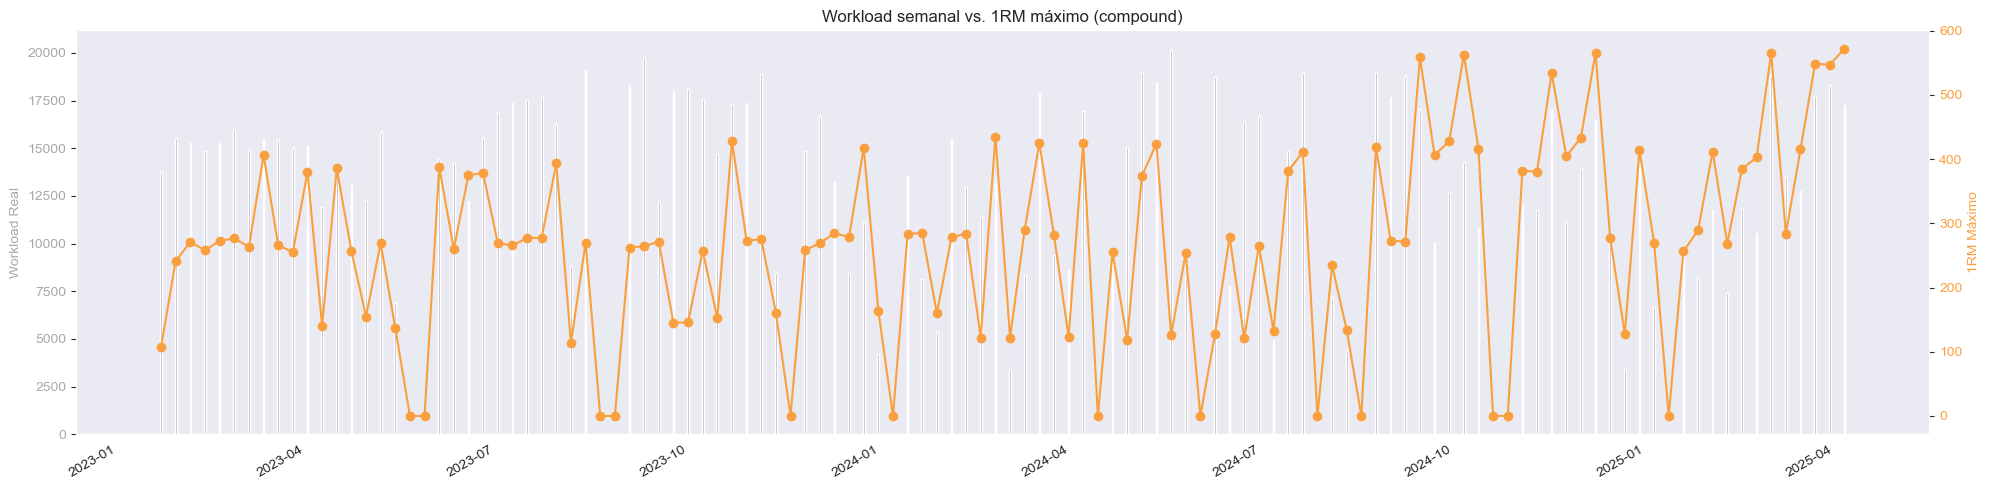

In [22]:
fig, ax1 = plt.subplots(figsize=(20, 5))

# Primer eje Y (barra): workload_real
ax1.bar(compound_aggregate_deeper["fecha"], compound_aggregate_deeper["workload_real"], color="darkgray", label="Workload Real")
ax1.set_ylabel("Workload Real", color="darkgray")
ax1.tick_params(axis="y", labelcolor="darkgray")

# Segundo eje Y (línea): 1RM
ax2 = ax1.twinx()
ax2.plot(compound_aggregate_deeper["fecha"], compound_aggregate_deeper["1rm"], color="#fa9f3d", marker="o", label="1RM Máximo")
ax2.set_ylabel("1RM Máximo", color="#fa9f3d")
ax2.tick_params(axis="y", labelcolor="#fa9f3d")

fig.autofmt_xdate()
plt.title("Workload semanal vs. 1RM máximo (compound)")
plt.tight_layout()
plt.show()

**Sets by rir range**

In [23]:
# Calculate min and max dates
min_date = date(2025,1,1)
max_date = series_muscles_merged['fecha'].dt.date.max()

# Calculate the duration of the period
duration = max_date - min_date

# Calculate the previous period
previous_min_date = min_date - duration + timedelta(days=-1)
previous_max_date = max_date - duration + timedelta(days=-1)

print(f"Current Period: {min_date} to {max_date}")
print(f"Previous Period: {previous_min_date} to {previous_max_date}")

Current Period: 2025-01-01 to 2025-04-04
Previous Period: 2024-09-29 to 2024-12-31


In [24]:
series_muscles_merged['period'] = np.where((series_muscles_merged.fecha.dt.date >= min_date) & (series_muscles_merged.fecha.dt.date <= max_date), 'current',
                                    np.where((series_muscles_merged.fecha.dt.date >= previous_min_date) & (series_muscles_merged.fecha.dt.date <= previous_max_date), 'previous', None))

series_muscles_merged.loc[series_muscles_merged.period.notnull()].groupby(['rir_range','period'])['id_serie'].nunique().unstack()

period,current,previous
rir_range,,
F|0,544,547
1|2|3,564,443
4,24,37
+5,37,20


**Assess Isolate Exercises**

In [25]:
track_record_aggregated[['progress_tracker','exercise']].value_counts()

progress_tracker  exercise              
Isolate           Calf raise on machine     394
                  Dumbbell lateral raise    380
                  Preacher curl machine     366
Compound          Pull-ups                  354
                  Parallel bar dips         296
Isolate           Incline machine press     259
Compound          Romanian deadlift         225
Isolate           Machine row               189
Compound          Smith machine squat       109
                  Parallel bar dips 210      29
Name: count, dtype: int64

<Axes: title={'center': 'Workload semanal vs. Peso máximo (todas las series)'}, xlabel='fecha'>

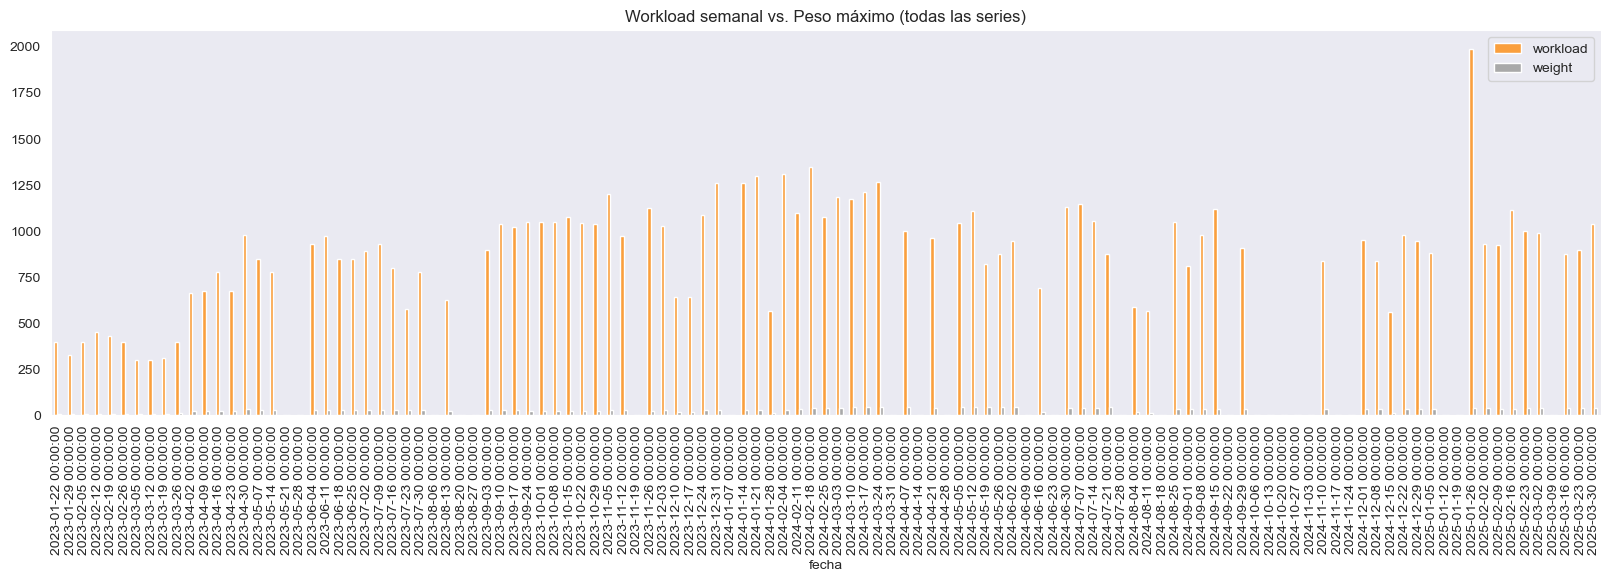

In [26]:
track_record_aggregated.loc[track_record_aggregated.exercise == 'Preacher curl machine']\
    .groupby(pd.Grouper(key='fecha', freq='w'))\
    .agg({'workload':'sum','weight':'max'}).plot(kind='bar', figsize=(20,5), color=['#fa9f3d','darkgray'], title='Workload semanal vs. Peso máximo (todas las series)', legend=True)

**Compuestos**

In [27]:
def workload_and_weight(df, exercise: str, y: str):    
    fig, ax1 = plt.subplots(figsize=(12, 4))

    data = df[df.exercise_no_tempo == exercise]

    # Primer eje: workload
    sns.lineplot(data=data, x='fecha', y='workload', ax=ax1, label='Workload', color='tab:blue')
    ax1.set_ylabel('Workload', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Segundo eje: real_weight
    ax2 = ax1.twinx()
    sns.lineplot(data=data, x='fecha', y=y, ax=ax2, label=str.capitalize(y), color='tab:orange')
    ax2.set_ylabel(str.capitalize(y), color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    # Título
    ax1.set_title(f'Evolución de {exercise}')

    plt.tight_layout()
    plt.show()

In [28]:
compound = series_muscles_merged.loc[
           (series_muscles_merged.progress_tracker == 'Compound')].groupby([pd.Grouper(key='fecha', freq='d'),'exercise_no_tempo'])[['1rm','workload']].agg({'workload':'sum','1rm':'max'}).reset_index()

compound_exercises = compound.exercise_no_tempo.unique().tolist()

**Muscles**

In [29]:
# Calculate min and max dates
min_date = date(2025,3,15)
max_date = series_muscles_merged['fecha'].dt.date.max()

# Calculate the duration of the period
duration = max_date - min_date

# Calculate the previous period
previous_min_date = min_date - duration + timedelta(days=-1)
previous_max_date = max_date - duration + timedelta(days=-1)

map_back = {
    'Dorsales':'Espalda',
    'Espalda alta':'Espalda',
    'Espalda media-baja':'Espalda'
}

series_muscles_merged['id_muscle_2'] = series_muscles_merged.id_muscle.apply(lambda x: map_back.get(x, x))

muscle_sets_curr = series_muscles_merged.loc[series_muscles_merged.fecha.dt.date.between(min_date, max_date)].copy()
muscle_sets_prev = series_muscles_merged.loc[series_muscles_merged.fecha.dt.date.between(previous_min_date, previous_max_date)].copy()

muscle_sets_curr = muscle_sets_curr\
    .groupby('id_muscle_2')\
    [['series_counter','effective_set_counter','series_principal','workload_real']].sum().reset_index()

muscle_sets_curr['%_effective_set'] = np.round(muscle_sets_curr.effective_set_counter / muscle_sets_curr.series_counter, 2) *100

muscle_sets_prev = muscle_sets_prev\
    .groupby('id_muscle_2')\
    [['series_counter','effective_set_counter','series_principal','workload_real']].sum().reset_index()

muscle_sets_prev['%_effective_set'] = np.round(muscle_sets_prev.effective_set_counter / muscle_sets_prev.series_counter, 2) * 100

muscle_sets = muscle_sets_curr.merge(muscle_sets_prev, how='left', on='id_muscle_2', suffixes=('_curr','_prev'))

for col in muscle_sets_curr.columns:
    if col not in ['id_muscle_2']:
        if col != 'workload_real':
            muscle_sets[f'delta_{col}'] = muscle_sets[col + '_curr'] - muscle_sets[col + '_prev']
        else:
            muscle_sets[f'delta_{col}'] = np.round(muscle_sets[col + '_curr'] / muscle_sets[col + '_prev'] - 1, 2) * 100

In [30]:
table_1 = muscle_sets[['series_principal_curr','delta_series_principal','series_counter_curr','delta_series_counter']].copy()

table_2 = muscle_sets[['series_counter_curr','effective_set_counter_curr','delta_effective_set_counter','%_effective_set_curr','delta_%_effective_set']].copy()

table_3 = muscle_sets[['workload_real_curr','delta_workload_real']].copy()

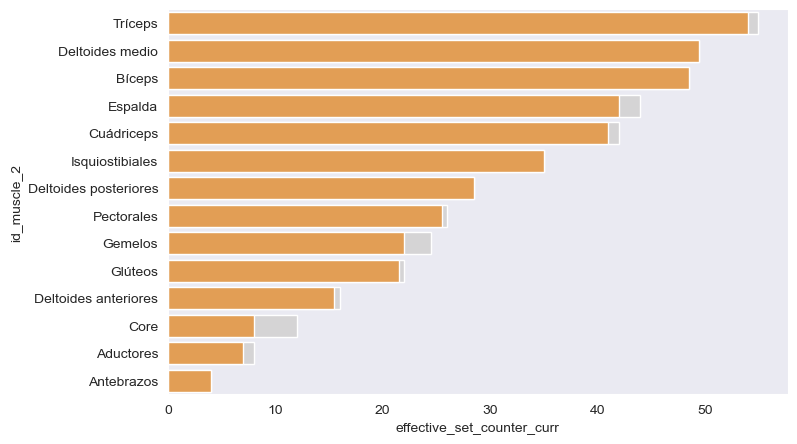

In [31]:
fig, ax = plt.subplots(figsize=(8,5))

sns.barplot(data=muscle_sets.sort_values(by='series_counter_curr', ascending=False),
            y='id_muscle_2', 
            x='series_counter_curr',
            color='#d5d4d5',
            ax=ax)

sns.barplot(data=muscle_sets.sort_values(by='effective_set_counter_curr', ascending=False),
            y='id_muscle_2', 
            x='effective_set_counter_curr',
            color='#fa9f3d',
            ax=ax)

plt.show()

In [41]:
muscle_sets

,id_muscle_2,series_counter_curr,effective_set_counter_curr,series_principal_curr,workload_real_curr,%_effective_set_curr,series_counter_prev,effective_set_counter_prev,series_principal_prev,workload_real_prev,%_effective_set_prev,delta_series_counter,delta_effective_set_counter,delta_series_principal,delta_workload_real,delta_%_effective_set
0,Aductores,12.0,7.0,12,14400.0,58.0,4.0,4.0,4.0,4200.00,100.0,8.0,3.0,8.0,243.0,-42.0
1,Antebrazos,4.0,4.0,4,3375.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bíceps,48.5,48.5,32,18437.4,100.0,37.0,37.0,20.0,16999.50,100.0,11.5,11.5,12.0,8.0,0.0
3,Core,8.0,8.0,8,7185.3,100.0,9.0,9.0,9.0,9427.05,100.0,-1.0,-1.0,-1.0,-24.0,0.0
4,Cuádriceps,44.0,41.0,44,40246.0,93.0,45.0,39.0,45.0,39019.50,87.0,-1.0,2.0,-1.0,3.0,6.0
5,Deltoides anteriores,16.0,15.5,0,5268.4,97.0,12.0,12.0,0.0,4894.00,100.0,4.0,3.5,0.0,8.0,-3.0
6,Deltoides medio,49.5,49.5,39,9468.5,100.0,44.0,44.0,31.0,9992.00,100.0,5.5,5.5,8.0,-5.0,0.0
7,Deltoides posteriores,28.5,28.5,12,10971.6,100.0,21.0,21.0,4.0,10833.00,100.0,7.5,7.5,8.0,1.0,0.0
8,Espalda,42.0,42.0,42,27979.6,100.0,44.0,44.0,44.0,30784.20,100.0,-2.0,-2.0,-2.0,-9.0,0.0
9,Gemelos,22.0,22.0,22,42092.0,100.0,29.0,29.0,29.0,60012.00,100.0,-7.0,-7.0,-7.0,-30.0,0.0


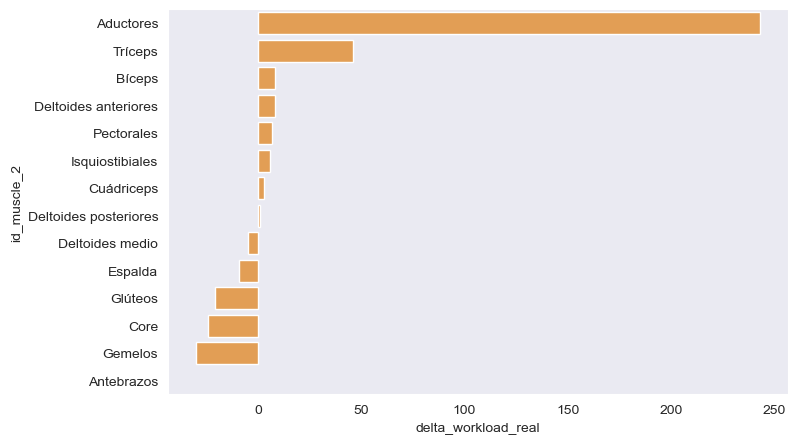

In [45]:
fig, ax = plt.subplots(figsize=(8,5))

sns.barplot(data=muscle_sets.sort_values(by='delta_workload_real', ascending=False),
            y='id_muscle_2', 
            x='delta_workload_real',
            color='#fa9f3d',
            ax=ax)

plt.show()

---

<Axes: xlabel='fecha', ylabel='1rm'>

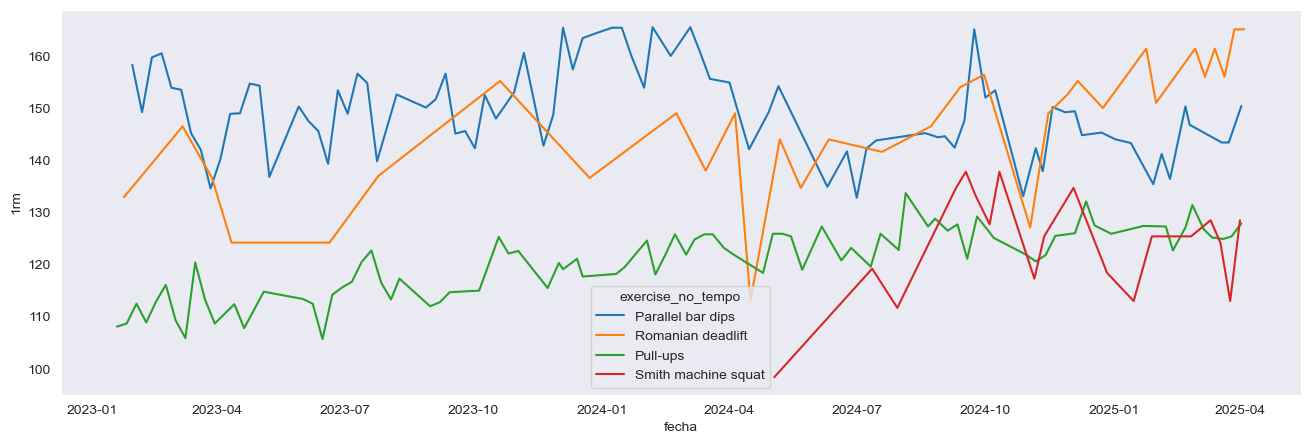

In [34]:
fig, ax = plt.subplots(figsize=(16,5))
sns.lineplot(data=compound, x='fecha', y='1rm', hue='exercise_no_tempo')

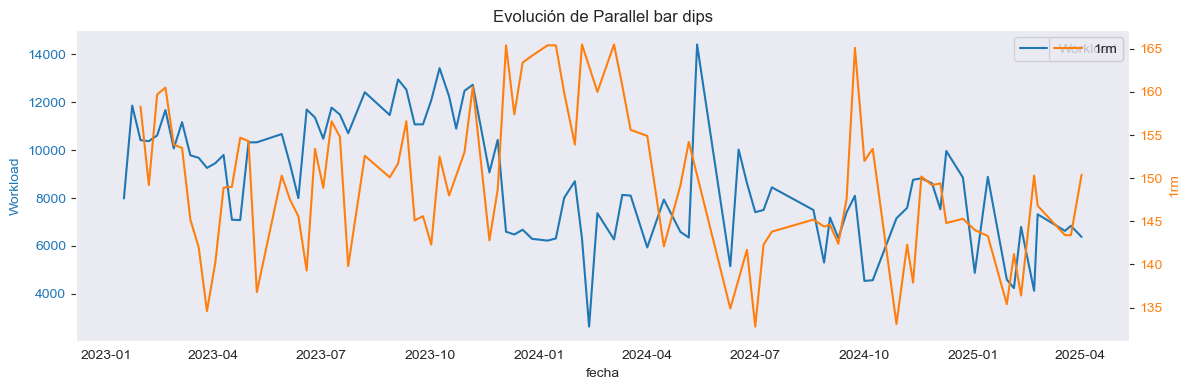

In [35]:
workload_and_weight(compound, compound_exercises[0], '1rm')

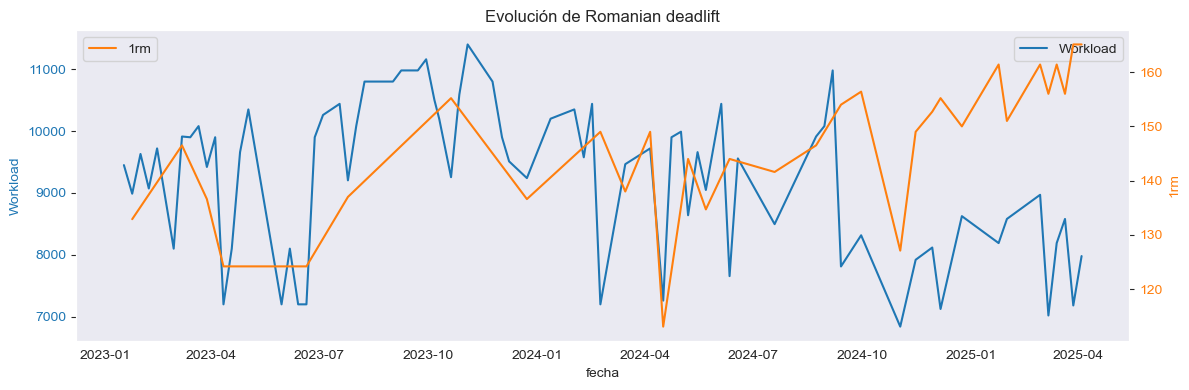

In [36]:
workload_and_weight(compound, compound_exercises[1], '1rm')

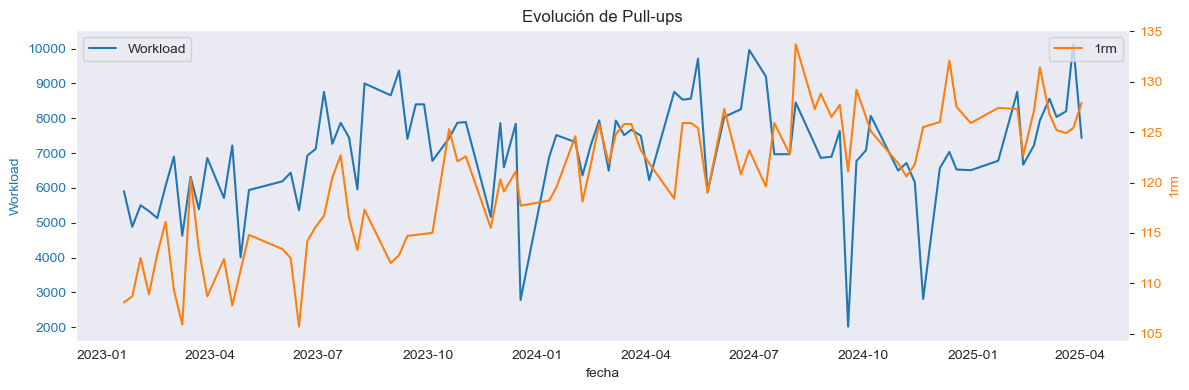

In [37]:
workload_and_weight(compound, compound_exercises[2], '1rm')

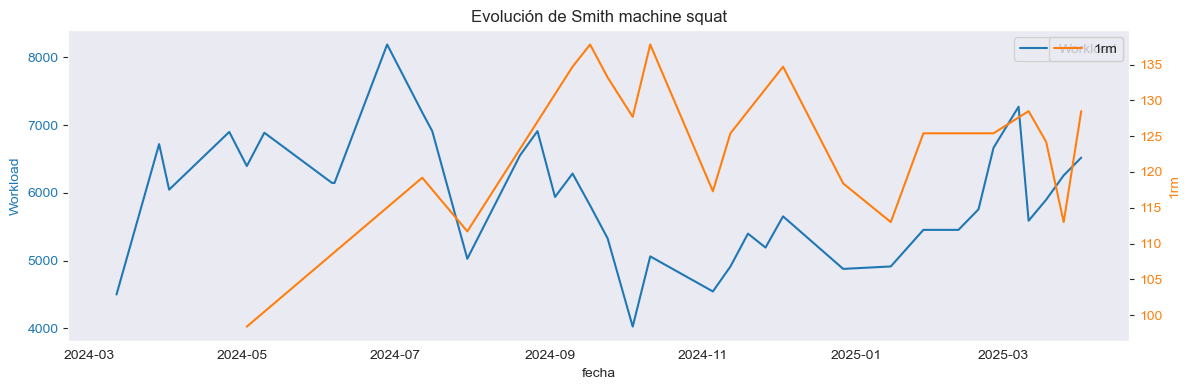

In [38]:
workload_and_weight(compound, compound_exercises[3], '1rm')

**Aislamiento**

In [39]:
isolate = series_muscles_merged.loc[
           (series_muscles_merged.progress_tracker == 'Isolate')].groupby([pd.Grouper(key='fecha', freq='w'),'exercise_no_tempo'])[['workload','real_weight']].agg({'workload':'sum','real_weight':'max'}).reset_index()

exercises = isolate.exercise_no_tempo.unique().tolist()

In [40]:
workload_and_weight(isolate, exercises[0])

TypeError: workload_and_weight() missing 1 required positional argument: 'y'

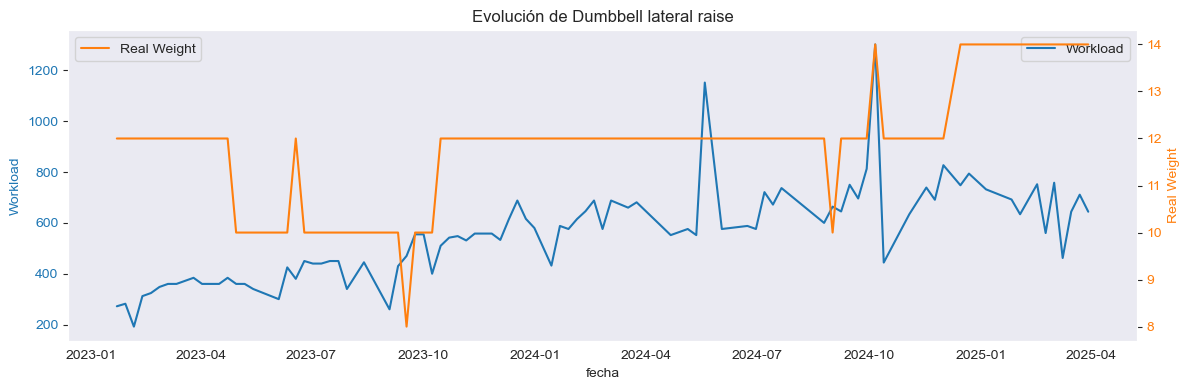

In [ ]:
workload_and_weight(isolate, exercises[1])

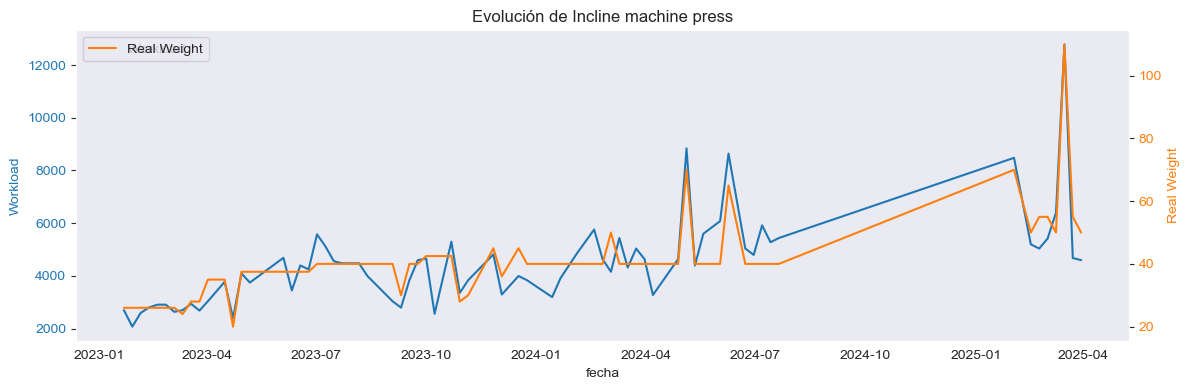

In [ ]:
workload_and_weight(isolate, exercises[2])

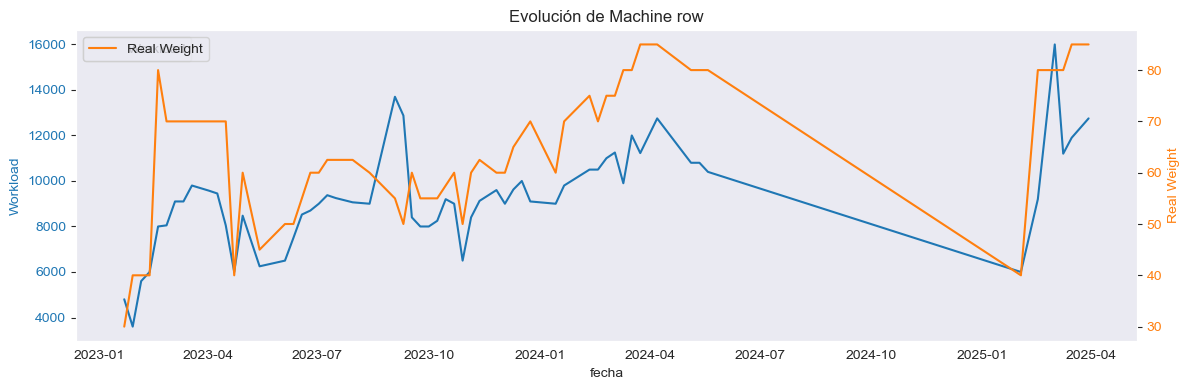

In [ ]:
workload_and_weight(isolate, exercises[3])

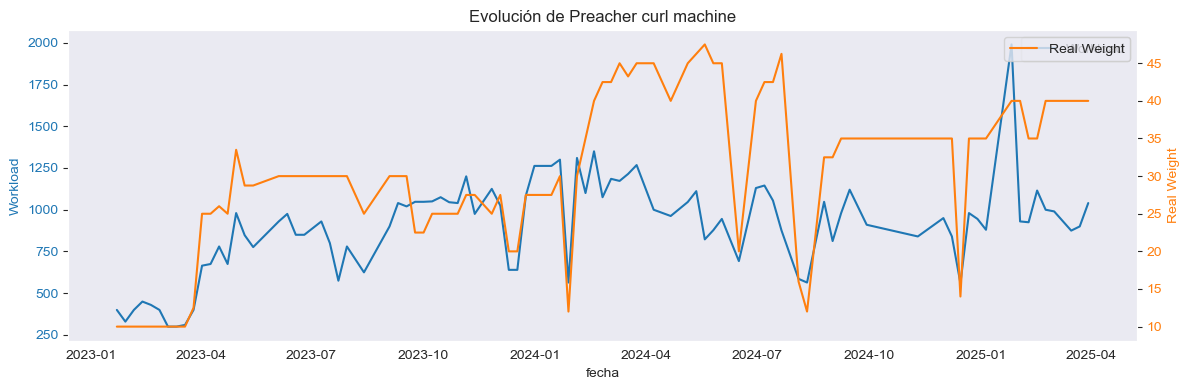

In [ ]:
workload_and_weight(isolate, exercises[4])

---

### **Relation of RIR & Workload between sets**

In [ ]:
df['series_number'] = df.groupby(['routine','date','exercise']).cumcount() + 1
df['rank_workload'] = df.groupby(['date','exercise'])['workload'].rank(method='dense', ascending=False)
df['rank_rir'] = df.groupby(['date','exercise'])['rir'].rank(method='dense')

In [ ]:
def rank_by(df, col: str):
    total_by_series = df.groupby('series_number')['exercise'].count().reset_index()
    col_by_series = df.groupby(['series_number',col])['exercise'].count().reset_index()
    col_by_series = col_by_series.merge(total_by_series, how='left', on='series_number', suffixes=('','_new'))
    col_by_series.rename(columns={'exercise':'sets', 'exercise_new':'total'}, inplace=True)
    col_by_series['%_sets'] = np.round(col_by_series['sets']/col_by_series['total'],4)
    col_by_series.drop('total', axis=1, inplace=True)
    pivot = pd.pivot_table(data=col_by_series, index='series_number', columns=col, values='%_sets', aggfunc='max').style.background_gradient('vlag_r', axis=1)

    return col_by_series, pivot

In [ ]:
rir_by_series, pivot_rir = rank_by(df, 'rank_rir')

In [ ]:
comb_series_rank = df[['series_number','rank_workload','rank_rir']].value_counts().sort_index().reset_index().reset_index()
comb_series_rank.rename(columns={'index':'type_comb'}, inplace=True)

In [ ]:
df_merged = df.merge(comb_series_rank.drop('count', axis=1), on=['series_number','rank_workload','rank_rir'], how='left')

In [ ]:
df_merged['exercise_1PS'] = df_merged.exercise.shift(1)
df_merged['exercise_2PS'] = df_merged.exercise.shift(2)
df_merged['exercise_3PS'] = df_merged.exercise.shift(3)
df_merged['exercise_4PS'] = df_merged.exercise.shift(4)
df_merged['exercise_5PS'] = df_merged.exercise.shift(5)

df_merged['workload_1PS'] = np.where(df_merged.exercise_1PS != df_merged.exercise, np.nan, df_merged.workload.shift(1))
df_merged['workload_2PS'] = np.where(df_merged.exercise_2PS != df_merged.exercise, np.nan, df_merged.workload.shift(2))
df_merged['workload_3PS'] = np.where(df_merged.exercise_3PS != df_merged.exercise, np.nan, df_merged.workload.shift(3))
df_merged['workload_4PS'] = np.where(df_merged.exercise_4PS != df_merged.exercise, np.nan, df_merged.workload.shift(4))
df_merged['workload_5PS'] = np.where(df_merged.exercise_5PS != df_merged.exercise, np.nan, df_merged.workload.shift(5))

df_merged['rir_1PS'] = np.where(df_merged.exercise_1PS != df_merged.exercise, np.nan, df_merged.rir.shift(1))
df_merged['rir_2PS'] = np.where(df_merged.exercise_2PS != df_merged.exercise, np.nan, df_merged.rir.shift(2))
df_merged['rir_3PS'] = np.where(df_merged.exercise_3PS != df_merged.exercise, np.nan, df_merged.rir.shift(3))
df_merged['rir_4PS'] = np.where(df_merged.exercise_4PS != df_merged.exercise, np.nan, df_merged.rir.shift(4))
df_merged['rir_5PS'] = np.where(df_merged.exercise_5PS != df_merged.exercise, np.nan, df_merged.rir.shift(5))

df_merged['repreal_1PS'] = np.where(df_merged.exercise_1PS != df_merged.exercise, np.nan, df_merged.repreal.shift(1))

df_merged.drop(['exercise_1PS','exercise_2PS','exercise_3PS','exercise_4PS','exercise_5PS'], axis=1, inplace=True)

df_merged['workload_less1PS'] = np.where(df_merged.workload_1PS.isnull(), np.nan, np.where(df_merged.workload >= df_merged.workload_1PS, 1, 0))
df_merged['workload_less2PS'] = np.where(df_merged.workload_2PS.isnull(), np.nan, np.where(df_merged.workload >= df_merged.workload_2PS, 1, 0))
df_merged['workload_less3PS'] = np.where(df_merged.workload_3PS.isnull(), np.nan, np.where(df_merged.workload >= df_merged.workload_3PS, 1, 0))
df_merged['workload_less4PS'] = np.where(df_merged.workload_4PS.isnull(), np.nan, np.where(df_merged.workload >= df_merged.workload_4PS, 1, 0))
df_merged['workload_less5PS'] = np.where(df_merged.workload_5PS.isnull(), np.nan, np.where(df_merged.workload >= df_merged.workload_5PS, 1, 0))

df_merged['rir_less1PS'] = np.where(df_merged.rir_1PS.isnull(), np.nan, np.where(df_merged.rir >= df_merged.rir_1PS, 1, 0))
df_merged['rir_less2PS'] = np.where(df_merged.rir_2PS.isnull(), np.nan, np.where(df_merged.rir >= df_merged.rir_2PS, 1, 0))
df_merged['rir_less3PS'] = np.where(df_merged.rir_3PS.isnull(), np.nan, np.where(df_merged.rir >= df_merged.rir_3PS, 1, 0))
df_merged['rir_less4PS'] = np.where(df_merged.rir_4PS.isnull(), np.nan, np.where(df_merged.rir >= df_merged.rir_4PS, 1, 0))
df_merged['rir_less5PS'] = np.where(df_merged.rir_5PS.isnull(), np.nan, np.where(df_merged.rir >= df_merged.rir_5PS, 1, 0))

df_merged.drop(['workload_1PS','workload_2PS','workload_3PS','workload_4PS','workload_5PS','rir_1PS','rir_2PS','rir_3PS','rir_4PS','rir_5PS'], axis=1, inplace=True)

df_merged['workload_and_rir_less1PS'] = np.where((df_merged.repreal < 2 * df_merged.repreal_1PS) & (df_merged.workload_less1PS == 1) & (df_merged.rir_less1PS == 1),1,0)

In [ ]:
df_merged.groupby('year_week')[['workload_and_rir_less1PS']].sum().plot(kind='bar', figsize=(20,4))

KeyError: 'year_week'

In [ ]:
series_by_muscle = df_merged.loc[df_merged.date.dt.year > 2023].groupby('exercise')['series_number'].count().reset_index()
pivot = df_merged.loc[df_merged.date.dt.year > 2023].groupby(['exercise','year_month'])['workload_and_rir_less1PS'].sum().unstack()
pivot['total'] = pivot.sum(1)
pivot = pivot.merge(series_by_muscle, how='left', left_index=True, right_on='exercise')
pivot['total_%'] = np.round(pivot.total/pivot.series_number,4)
pivot.sort_values(by='total', ascending=False)

,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,total,exercise,series_number,total_%
26,1.0,2.0,3.0,2.0,1.0,6.0,2.0,3.0,3.0,1.0,4.0,2.0,3.0,2.0,1.0,36.0,Leg extension,280,0.1286
55,NaN,2.0,5.0,0.0,3.0,0.0,2.0,3.0,3.0,2.0,5.0,2.0,2.0,2.0,1.0,32.0,Unilateral french press,197,0.1624
47,1.0,0.0,0.0,1.0,3.0,4.0,3.0,1.0,1.0,2.0,3.0,3.0,5.0,0.0,5.0,32.0,Single-leg leg extension,167,0.1916
45,1.0,5.0,2.0,1.0,1.0,1.0,2.0,3.0,3.0,0.0,6.0,1.0,2.0,1.0,1.0,30.0,Single-arm cable rear delt fly,199,0.1508
9,4.0,5.0,2.0,2.0,0.0,2.0,2.0,2.0,1.0,0.0,3.0,1.0,2.0,1.0,1.0,28.0,Dumbbell lateral raise,211,0.1327
44,1.0,2.0,0.0,2.0,3.0,2.0,0.0,0.0,1.0,0.0,2.0,4.0,4.0,NaN,4.0,25.0,Seated leg curl,168,0.1488
7,0.0,2.0,2.0,2.0,3.0,2.0,1.0,1.0,1.0,2.0,0.0,1.0,4.0,2.0,2.0,25.0,Calf raise on machine,228,0.1096
49,NaN,2.0,3.0,4.0,3.0,0.0,2.0,1.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,23.0,Smith machine calf raise,209,0.1100
38,2.0,4.0,3.0,0.0,2.0,0.0,1.0,1.0,1.0,NaN,0.0,1.0,2.0,2.0,1.0,20.0,Preacher curl machine,198,0.1010
42,1.0,2.0,0.0,0.0,2.0,4.0,1.0,3.0,2.0,1.0,1.0,1.0,2.0,0.0,0.0,20.0,Rope triceps extension,235,0.0851


### **MAX by exercise**

In [ ]:
max_exercise = df.loc[df.repreal > 0, ['exercise','weight','date']].sort_values(by=['exercise','weight','date'], ascending=[True, False, False])
max_exercise['max'] = max_exercise.groupby(['exercise']).cumcount() + 1
count_dates = max_exercise.groupby(['exercise','weight'])['date'].nunique().reset_index()
max_exercise = max_exercise[max_exercise['max'] == 1]
max_exercise = max_exercise.merge(count_dates, how='left', on=['exercise','weight'], suffixes=('','_new'))
max_exercise.rename(columns={'date_new':'days'}, inplace=True)

In [ ]:
max_exercise.sort_values(by='weight', ascending=False)

,exercise,weight,date,max,days
31,Incline leg press,260,2023-07-21,1,4
27,Hip thrust,210,2024-12-06,1,1
13,Conventional deadlift,200,2023-09-15,1,1
11,Calf raise on machine,200,2025-03-21,1,3
64,Sumo squat,160,2024-03-05,1,2
60,Smith machine calf raise,160,2023-04-28,1,2
45,Parallel bar dips,137,2024-02-19,1,2
4,Barbell squat,135,2023-04-11,1,2
34,Leg extension,130,2025-03-18,1,3
52,Romanian deadlift,130,2025-03-21,1,7
